In [1]:
import matplotlib.pyplot as plt
import plotly.offline as py
import numpy  as np
import pandas as pd
import scipy.stats as st

%matplotlib inline
plt.style.use('physics')

plt.rcParams['axes.grid'       ]  = False
plt.rcParams['xtick.labelsize' ]  = 14
plt.rcParams['ytick.labelsize' ]  = 14
plt.rcParams['axes.labelsize'  ]  = 14
plt.rcParams['legend.fancybox' ]  = False

pd.options.mode.chained_assignment = None

In [2]:
from histimator.models import HistiModel, HistiChannel, HistiSample
from histimator import models
from histimator.estimator import BinnedLH

from probfit import gen_toy
from iminuit import Minuit, describe
from pprint import pprint

In [3]:
def theory_model(x, mu):
    """poisson pdf, parameter lamb is the fit parameter"""
    return mu*st.norm(4,scale=1).pdf(x) + (1-mu)*st.expon(scale=4).pdf(x)

In [312]:
ff = 0.3 
np.random.seed(42)

bounds  = (0, 10)
xbin    = np.linspace(0,10,21)
data    = np.random.poisson(5000*theory_model(xbin, ff))
hist_s  = np.random.poisson(5000*ff*st.norm(4,scale=1).pdf(xbin)).astype(np.float64)
hist_b  = np.random.poisson(5000*(1-ff)*st.expon(scale=4).pdf(xbin)).astype(np.float64)
binedge = xbin-np.diff(xbin)[0]/2.0 
binedge = np.append(binedge, [xbin.max() + np.diff(xbin)[0]/2.0])

In [313]:
m = HistiModel('model')

signal = HistiSample("signal")
signal.SetHisto((hist_s, binedge))
signal.AddNorm("mu", 1.0,0,3)

background = HistiSample("background1")
background.SetHisto((hist_b, binedge))

chan = HistiChannel("SR")
chan.AddSample(signal)
chan.AddSample(background)

m.AddChannel(chan)
chan.SetData(data)
m.AddChannel(chan)

In [314]:
def plot_model(model,true_mu=1.0, fitted_mu=None):
    plt.figure(figsize=(5,5))
    t = np.linspace(0,10,1000)
    pred = np.asarray([model.pdf(i, true_mu)*0.5 for i in t])
    plt.plot(t, pred, color='black', label='model')
    plt.errorbar(
        xbin, data, yerr=np.sqrt(data), fmt='.', ms=14, capsize=0, color='black', label='data'
    )
    if fitted_mu is not None:
        pred_fitted = np.asarray([model.pdf(i, fitted_mu)*0.5 for i in t])
        plt.plot(t, pred_fitted, color='green', label='fitted pdf')
    plt.xlabel('X (obs)')
    plt.ylabel('dN/dX')
    plt.legend()

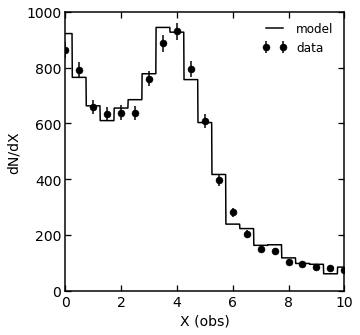

In [315]:
plot_model(m)

In [124]:
print "---- printing model --- "
pprint (chan.__dict__)
for n_, s_ in chan.__dict__['samples'].items():
    print '---- sample : ', n_
    pprint (s_.__dict__)
print "---------------------------- "

---- printing model --- 
{'data': array([170, 163, 124, 129, 134, 120, 148, 176, 188, 154, 121,  74,  57,
        42,  28,  30,  17,  17,  16,  17,  15]),
 'n_samples': 2,
 'name': 'SR',
 'samples': {'background1': <histimator.models.HistiSample object at 0x1125d2390>,
             'signal': <histimator.models.HistiSample object at 0x1125d20d0>}}
---- sample :  signal
{'bincontent': array([  0.,   0.,   0.,   5.,  17.,  45.,  64., 116., 127.,  87.,  61.,
        41.,   8.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
 'binedges': array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,
        4.25,  4.75,  5.25,  5.75,  6.25,  6.75,  7.25,  7.75,  8.25,
        8.75,  9.25,  9.75, 10.25]),
 'hist': (array([  0.,   0.,   0.,   5.,  17.,  45.,  64., 116., 127.,  87.,  61.,
        41.,   8.,   7.,   2.,   0.,   0.,   0.,   0.,   0.,   0.]),
          array([-0.25,  0.25,  0.75,  1.25,  1.75,  2.25,  2.75,  3.25,  3.75,
        4.25,  4.75,  5.25,  5.75,  6.25,  6.75,  

In [404]:
from scipy.stats._distn_infrastructure import rv_continuous
from histimator.interpolation import Interpolate

class backend(object):
    def __init__(self):
        pass
    def astensor(self, tensor ,name, dtype=np.float32):
        return np.asarray(tensor).astype(dtype)
    
    
K = backend()

class fake_func_code(object):
    def __init__(self, arg):
        self.co_varnames = list(arg)
        self.co_argcount = len(arg)

    def append(self, varname):
        tmp = list(self.co_varnames)
        if isinstance(varname, list):
            for par in varname :
                if par not in tmp: tmp.append(par)
        else:
            if varname not in tmp: tmp.append(varname)
        self.co_varnames = list(tmp)
        self.co_argcount = len(self.co_varnames)


class Histogram(object):
    def __init__(self, histogram, name='obs', **kwargs):
        """
        Create a new distribution using the given histogram
        
        Parameters
        ----------
        histogram : tuple of array_like
          Tuple containing two array_like objects
          The first containing the content of n bins
          The second containing the (n+1) bin boundaries
          In particular the return value np.histogram is accepted
          
        inpired from scipy implemnetation
        """
        self._histogram = histogram
        if len(histogram) > 3:
            raise ValueError("Expected length < 3 for parameter histogram")
        
        self._hpdf = K.astensor(histogram[0], name = name + '_hist')
        self._hbins = K.astensor(histogram[1], name = name + '_bins')
        self._errs = None
        if (histogram) == 3:
            self._errs = K.astensor(histogram[2], name = name + '_error')
        self._hbin_widths = self._hbins[1:] - self._hbins[:-1]
        self._hcdf = np.cumsum(self._hpdf * self._hbin_widths)
        self._hpdf = np.hstack([0.0, self._hpdf, 0.0])
        self._hcdf = np.hstack([0.0, self._hcdf])
        
        self.kwargs = kwargs
        self.name = name
        self.func_code = fake_func_code(self.kwargs.keys())
        self.func_defaults = None
        self.is_normed = False
    
    def pdf(self, x):
        return self._hpdf[np.searchsorted(self._hbins, x, side='right')]
    def cdf(self, x):
        return np.interp(x, self._hbins, self._hcdf)
    def ppf(self, x):
        return np.interp(x, self._hcdf, self._hbins)
        
    def __call__(self, *args, **kwargs):
        if len(args) > 1:
            raise AttributeError(
                'univariate pdf, please check your arguments'
            )
        x = args[0]
        if len(kwargs) != 0:
            self.kwargs = kwargs
            self.func_code.append(kwargs.keys())
        print "co_varnames : ", self.func_code.co_varnames
        return self._hpdf[np.searchsorted(self._hbins, x, side='right')]
    
    
class NormedHistogram(Histogram):
    def __init__(self,histogram, name='obs',norm='N', **kwargs):
        super(NormedHistogram, self).__init__(histogram, name=name, **kwargs)
        self.norm_name = norm
        print "super : co_varnames:", self.func_code.co_varnames
        self.func_code.append(self.norm_name)
        print "super : co_varnames:", self.func_code.co_varnames
        self.is_normed = True
        
    def pdf(self, x, norm):
        return norm*self._hpdf[np.searchsorted(self._hbins, x, side='right')]
    
    def __call__(self, *args, **kwargs):
        if len(args) > 2:
            raise AttributeError(
                'normed univariate pdf takes at most two arguments'
            )
        x = args[0]
        norm = 1.0
        if len(kwargs) != 0:
            self.kwargs = kwargs
            self.func_code.append(kwargs.keys())
            norm = kwargs.get(self.norm_name, 1.0)
        else:
            norm = args[1]
        return self.pdf(x, norm)

In [405]:
class systematic(object):
    def __init__(self, pdf, name='syst', up=1., down=1., scheme=1.):
        self.pdf = pdf
        self.up = up
        self.down = down
        self.scheme = scheme
        
        self.name = name
        if name in describe(pdf):
            raise ValueError(
                '%s is already taken, please choose another name' % name
            )
        self.func_code = fake_func_code(name)
        self.func_defaults = None
        
    def __call__(self, *arg):
        feval = self.pdf(arg[0])
        alpha = arg[-1]
        inter = Interpolate(self.scheme)
        np.where(feval > 0, inter(alpha, feval, self.up, self.down), 0)

In [407]:
class Process(object):
    def __init__(self, name=None):
        self.name = name
        self.pois = {}
        self.nps = []
    
    def SetHistogram(self, histogram, name, normed=False, norm=1.0):
        if normed:
            self.pois[name] = {name : norm }
            self.pdf = NormedHistogram(histogram, name, norm)
        else:
            self.pdf = Histogram(histogram, name)
            
    def AddSystematic(self, name, uncert_up, uncert_down, scheme=1.0):
        self.nps.append(name)
        self.pdf = OverallSys(
            self.pdf, name, uncert_up, uncert_down, scheme
        )
    
class Channel(object):
    def __init__(self, name=None):
        self.name = name
        self.n_samples = 0
        self.samples = {}
        self.data = None

    def AddSample(self, sample):
        name = sample.name
        if name is None:
            name = 'sample_' + self.n_samples
        self.n_samples += 1
        self.samples[sample.name] = sample

    def SetData(self, data):
        self.data = data
        
class Model(object):
    def __init__(self, name='Model'):
        self.name = name
        self.n_channels = 0
        self.channels = []
        self.pdf = None
        self.data = None
        self.binedges = None
        self.pois = {}
        self.nps = []

    def AddChannel(self, channel):
        name = channel.name
        if name is None:
            name = 'channel_'+self.n_channels
        self.n_channels += 1
        self.channels.append(name)
        for sample in channel.samples:
            s = channel.samples[sample]
            for poi in s.pois:
                self.pois[poi] = s.pois[poi]
            self.nps.append(s.nps)
            if self.pdf is None:
                self.pdf = s.pdf
                self.binedges = s.binedges
            else:
                self.pdf = AddPdf(self.pdf, s.pdf)
        self.data = channel.data

    def Parameters(self):
        parameters = {'errordef': 1}
        for param in self.pois:
            name = param
            param = self.pois[param]
            parameters[name] = param['nom']
            parameters['limit_{}'.format(name)] = param['range']
            parameters['error_{}'.format(name)] = (
                param['range'][1]-param['range'][0]
            )/2.
        return parameters

In [408]:
pdf_s = NormedHistogram((hist_s, binedge), name='signal', norm='mu')
pdf_b = Histogram((hist_b, binedge), name='background')

super : co_varnames: []
super : co_varnames: ['mu']


In [397]:
m = Model('model')

signal = Sample("signal")
signal.SetHisto((hist_s, binedge))
signal.AddNorm("mu", 1.0,0,3)

background = HistiSample("background1")
background.SetHisto((hist_b, binedge))

chan = HistiChannel("SR")
chan.AddSample(signal)
chan.AddSample(background)

m.AddChannel(chan)
chan.SetData(data)
m.AddChannel(chan)

['mu']
['x', 'norm']


In [383]:
t = np.linspace(-0,10, 1000)

plt.plot(t, pdf_s(t))
plt.plot(t, pdf_s(t)+pdf_b(t))

kwargs :  {}
self.kwargs :  {}
args :  (array([ 0.        ,  0.01001001,  0.02002002,  0.03003003,  0.04004004,
        0.05005005,  0.06006006,  0.07007007,  0.08008008,  0.09009009,
        0.1001001 ,  0.11011011,  0.12012012,  0.13013013,  0.14014014,
        0.15015015,  0.16016016,  0.17017017,  0.18018018,  0.19019019,
        0.2002002 ,  0.21021021,  0.22022022,  0.23023023,  0.24024024,
        0.25025025,  0.26026026,  0.27027027,  0.28028028,  0.29029029,
        0.3003003 ,  0.31031031,  0.32032032,  0.33033033,  0.34034034,
        0.35035035,  0.36036036,  0.37037037,  0.38038038,  0.39039039,
        0.4004004 ,  0.41041041,  0.42042042,  0.43043043,  0.44044044,
        0.45045045,  0.46046046,  0.47047047,  0.48048048,  0.49049049,
        0.5005005 ,  0.51051051,  0.52052052,  0.53053053,  0.54054054,
        0.55055055,  0.56056056,  0.57057057,  0.58058058,  0.59059059,
        0.6006006 ,  0.61061061,  0.62062062,  0.63063063,  0.64064064,
        0.65065065,  0.6

IndexError: tuple index out of range

In [320]:
class mod(object):
    def __init__(self, name="model", **kwargs):
        self.kwargs =  kwargs
        self.name = name
        self.__code__ = fake_func_code(self.kwargs.keys())
        
    def __call__(self, *args, **kwargs):
        if len(kwargs) != 0:
            self.kwargs   =  kwargs
            self.__code__.append(kwargs.keys())
        print self.kwargs
        print args
        return pdf_s(*args, **kwargs)

In [239]:
g = mod("gauss", mu=0)
print g(5, mu=2)

describe(signal.pdf)

{'mu': 2}
(5,)
co_varnames :  ['N', 'momo', 'QU', 'mu']
61.0


['x', 'mu']

In [240]:
class add_pdf(object):
    def __init__(self, *args):
        self.args = args
        
    def __call__(self, *args, **kwargs):
        

IndentationError: expected an indented block (<ipython-input-240-96492df2fba7>, line 6)

In [31]:
add_pdf(signal.pdf, background.pdf)

(<histimator.pdfs.NormedHist instance at 0x11210bab8>, <histimator.pdfs.HistogramPdf object at 0x112116850>)
<class '__main__.add_pdf'>
['__call__', '__class__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'args']


In [9]:
blh = BinnedLH(m, bound=bounds, extended=True)

In [10]:
minimiser = Minuit(blh, SigXSecOverSM=1.0, limit_SigXSecOverSM  =(0,  2),
                   error_SigXSecOverSM=0.1, errordef=1)
minimiser.migrad()
minimiser.minos()
print 'migrad gives SigXSecOverSM as value', minimiser.values['SigXSecOverSM']

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning:

Exception Occured 
fcn is called with following arguments:
    SigXSecOverSM = +1.000000




TypeError: 'numpy.float64' object cannot be interpreted as an index

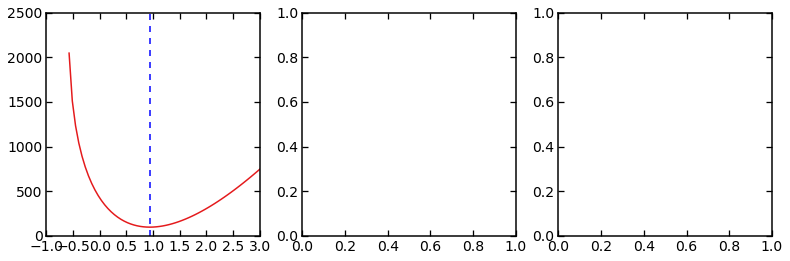

In [13]:
fig, ax = plt.subplots(1,3,figsize=(13,4))
t = np.linspace(-3,3, 100)
ax[0].plot(t, [blh(i) for i in t])
ax[0].axvline(minimiser.values['SigXSecOverSM'], ls='--')

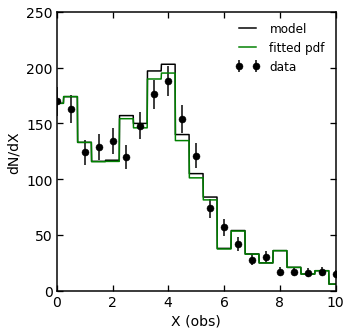

In [14]:
plot_model(m, 1.0, fitted_mu=minimiser.values['SigXSecOverSM'])